In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from transvae import trans_models
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *

In [2]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

This tutorial will demonstrate how to visualize and interpret model memory and how to evaluate model performance on a number of metrics. Full scripts for training models, generating samples and calculating attention weights are provided and instructions on how to use those scripts are included in the README. The functions demonstrated in this tutorial do not have pre-written high throughput scripts but can be used on larger input sizes if desired. 

# Model Reconstruction Performance

The reconstruction performance is a metric that assesses how useful the molecular embeddings within the model's memory are. If the reconstruction performance is low it means the embedded vectors do not contain enough structural information to adequately reconstruct the input sequence. Each model has a `reconstruct()` method that takes a set of SMILES, passes them through the model and returns the reconstructed sequences. With demonstrate this with the `RNNAttn-256` model below ***(note - this may take ~a minute to run)***

In [6]:
# Load model and set of SMILES
rnn = RNN(load_fn='checkpointz//10K_checkpoints//030_rnn-128_zinc.ckpt')
smiles_data = pd.read_csv('notebooks//example_data//zinc_smiles.txt').to_numpy()
smiles = smiles_data[:,0]

VAE_shell init called /n
RNN class init called /n
VAE_Shell load called /n
name
epoch
model_state_dict
optimizer_state_dict
best_loss
params
RNN class build_model called /n


In [7]:
rnn.params['BATCH_SIZE'] = 25
reconstructed_smiles = rnn.reconstruct(smiles_data, log=False, return_mems=False)
for og_smi, reconstructed_smi in zip(smiles, reconstructed_smiles):
    print('{} <- Original'.format(og_smi))
    print('{} <- Reconstruction'.format(reconstructed_smi))
    print('\n')

VAE_Shell reconstruct called /n
rnn-128_zinc
VAE_Shell greedy decode called /n
VAE_Shell greedy decode called /n
VAE_Shell greedy decode called /n
VAE_Shell greedy decode called /n
CCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1 <- Original
CC(=O)Nc1ccc(NC(=O)c2ccc(C)cc2)cc1 <- Reconstruction


CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1 <- Original
CC(=O)Nc1ccc(NC(=O)c2ccccc2)cc1 <- Reconstruction


Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO <- Original
COc1ccccc1NC(=O)c1ccc(Cl)cc1Cl <- Reconstruction


Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C <- Original
Cc1ccc(C(=O)N2CCCC2)cc1NC(=O)c1ccc(C(F)(F)F)cc1F <- Reconstruction


CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O <- Original
COc1ccc(C(=O)Nc2ccccc2)c(C)c1C#N <- Reconstruction


CCOC(=O)c1cncn1C1CCCc2ccccc21 <- Original
O=C(NCc1ccccc1)N1CCCCC1 <- Reconstruction


COc1ccccc1OC(=O)Oc1ccccc1OC <- Original
COc1ccccc1C(=O)Nc1ccc(Cl)cc1Cl <- Reconstruction


O=C1Nc2ccc(Cl)cc2C(c2ccccc2Cl)=NC1O <- Original
COc1ccc(C(=O)Nc2ccccc2)c(C)c1C#N <- Reconstruction


CN1C(=O)C(O)N=C(c2ccccc2Cl

The reconstruction performance of the `RNNAttn-256` is very good. It has only made one mistake on the 25 example SMILES (third from the last). To assess reconstruction performance more quantitatively, we can calculate token accuracies, SMILE accuracies and positional accuracies in bulk using the `calc_reconstruction_accuracies` function in the `tvae_util` module. Token accuracies are accuracies per token, SMILE accuracies are accuracies per SMILE string and positional accuracies are accuracies per sequence position.

In [9]:
# First we must tokenize the input and reconstructed smiles
input_smiles = []
for smi in smiles:
    input_smiles.append(tokenizer(smi))
output_smiles = []
for smi in reconstructed_smiles:
    output_smiles.append(tokenizer(smi))

Each SMILE is now a list of individual tokens like so 

`['C', 'C', 'C', 'S', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 
  'c', '2', '[nH]', 'c', '(', '=', 'N', 'C', '(', '=',  'O', 
  ')', 'O', 'C', ')', '[nH]', 'c', '2', 'c'  '1']`

In [10]:
smile_accs, token_accs, position_accs = calc_reconstruction_accuracies(input_smiles, output_smiles)

G:\GitHub\MSCSAM_TBD\main_model\transvae\tvae_util.py:207: RuntimeWarning: invalid value encountered in double_scalars
  position_acc.append(position_accs[0,i] / position_accs[1,i])


In [11]:
smile_accs, token_accs

(0.0, 0.208006718924972)

Token accuracies will generally be higher because being wrong on even one token will count as an incorrect SMILE reconstruction. The `RNNAttn-256` model scored 96% on SMILE reconstruction and 97.2% on token reconstruction for this small sample of input structures. We can also plot accuracy as a function of sequence position.

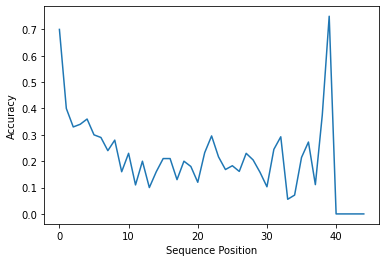

In [12]:
plt.plot(position_accs)
plt.xlabel('Sequence Position')
plt.ylabel('Accuracy')
plt.show()

On these 25 smiles, the `RNNAttn-256` model is above 95% accurate showing only one significant drop between sequence positions 35 and 40. However, this is a small sample size so it is not a good representation on how this model performs on molecules of this size in general. For this, you can read our analysis of model performance on the ZINC/PubChem datasets (shown below) or test your own models reconstruction accuracy on a larger sample size.

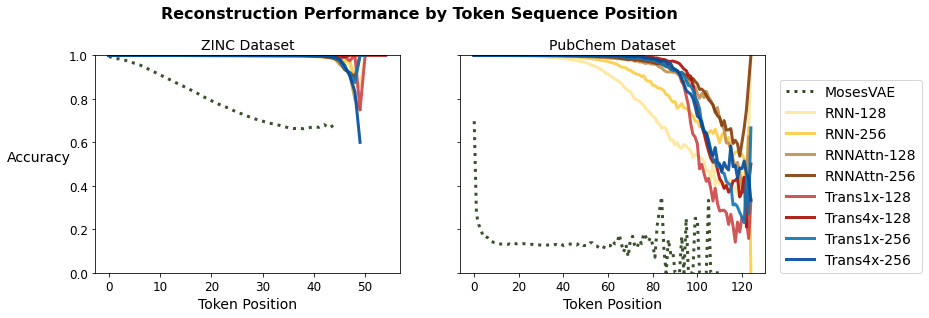

In [13]:
Image(filename='notebooks//example_data//reconstruction.png')

# Visualizing Model Memory

The memory of a model is analogous to the probability distribution of molecular embeddings that it has learned during training. A single molecular embedding is the size 128 vector at the center of the variational bottleneck. Each model has a built-in method for calculating and returning the model memory for a set of input structures, `calc_mems()`. ***(note - we plot the mean vector rather than the reparameterized vector so we can identify and analyze the meaningful latent dimensions)***

In [18]:
if rnn.model_type =='aae':
    mems, _, _ = rnn.calc_mems(smiles_data, log=False, save=False) 
elif rnn.model_type == 'wae':
    mems, _, _ = rnn.calc_mems(smiles_data, log=False, save=False) 
else:
    mems, mus, logvars = rnn.calc_mems(smiles_data, log=False, save=False) 

VAE_Shell cal_mems called /n
rnn-128_zinc


We can visualize the model memory by plotting a sample of molecular embeddings using `plt.imshow()`

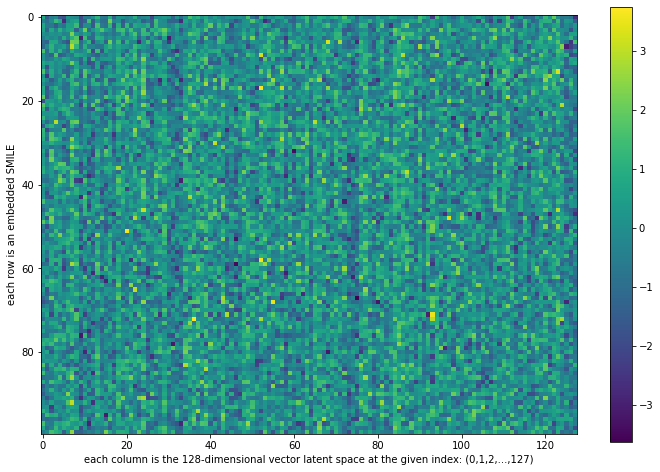

In [19]:
fig = plt.figure(figsize=(12,8))

plt.imshow(mems)
plt.xticks()
plt.yticks()
plt.ylabel("each row is an embedded SMILE")
plt.xlabel("each column is the 128-dimensional vector latent space at the given index: (0,1,2,...,127)")
plt.colorbar()
plt.show()

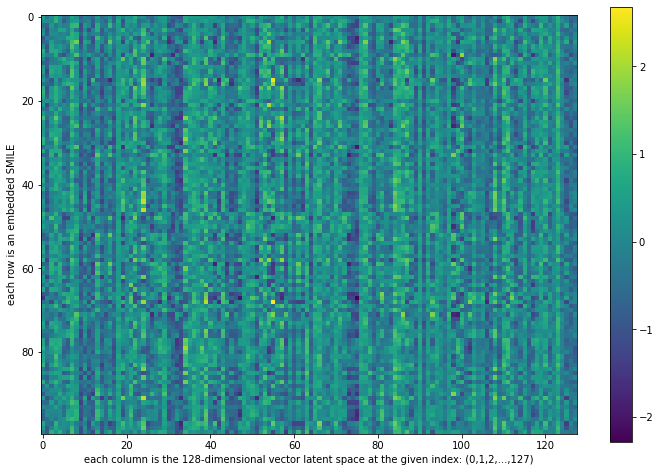

In [20]:
fig = plt.figure(figsize=(12,8))

plt.imshow(mus)
plt.xticks()
plt.yticks()
plt.ylabel("each row is an embedded SMILE")
plt.xlabel("each column is the 128-dimensional vector latent space at the given index: (0,1,2,...,127)")
plt.colorbar()
plt.show()

In [21]:
print(mus[0])

[ 0.56303155 -0.4031731   0.14318061  0.7799      0.25333506 -0.44455865
 -0.35306233  0.5712851   0.20455784 -0.74840003 -0.14653724 -0.3469068
 -0.57826996  0.35053605 -0.50260526 -0.19327237  0.15613304 -0.80235326
  0.4265828  -0.14910622  0.33890298  0.15996487  0.7833672  -0.02998175
  0.19843808 -0.44784632 -0.655915   -0.01533367  0.30993217  0.40533358
 -0.28051782 -0.7161659  -0.86813796 -0.9719636   0.70927495  0.46413785
  0.43803453  0.42804348  0.3358003   0.27321225  0.41415057  0.36566162
 -0.06341702  0.18986347 -0.53322774 -0.10935028 -0.33092016 -0.09733888
  0.28079244  0.5474041   0.3141869  -0.40722245  0.5075817   0.19863378
 -0.01866098 -0.21978088  0.4869787   0.8976133  -0.5245674   0.35842723
 -0.48437977  0.21347111 -0.09683516  0.6782057  -0.47827098  0.6318857
  0.7411152   0.05750827  0.12786043  0.05800236  0.38494813  0.4495038
  0.18310902 -0.34657025 -0.39558965 -0.43206942  0.5243006   0.54827833
  0.227087   -0.29330838 -0.10764109 -0.10968695 -0.08

CCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1


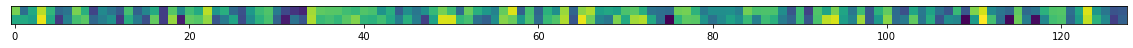

CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [22]:
print(smiles[0])
fig = plt.figure(figsize=(20,8))

plt.imshow(mus[0:2])

plt.xticks()
plt.yticks([])
plt.show()
print(smiles[1])

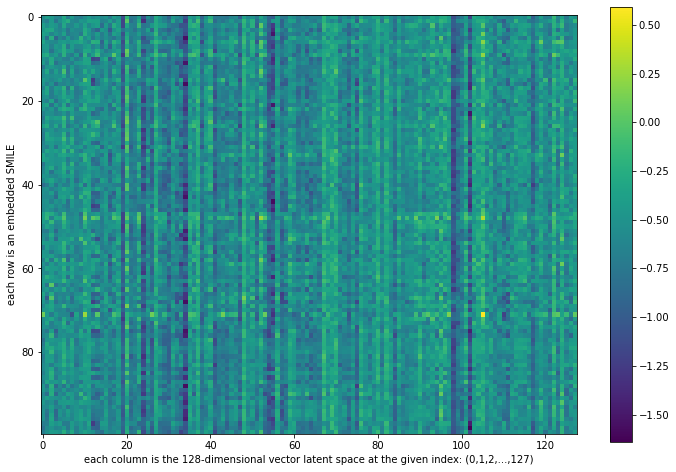

In [23]:
fig = plt.figure(figsize=(12,8))

plt.imshow(logvars)
plt.xticks()
plt.yticks()
plt.ylabel("each row is an embedded SMILE")
plt.xlabel("each column is the 128-dimensional vector latent space at the given index: (0,1,2,...,127)")
plt.colorbar()
plt.show()

For the `RNNAttn-256` model we see the selective memory structure. Some latent dimensions are more meaningful than others. We can calculate exactly how much information is stored in each dimension with the Shannon information entropy. Typically, you would want to calculate the entropy for a larger sample than the 25 SMILES we are using in this tutorial. 

In [24]:
vae_entropy_mems  = calc_entropy(mems)
vae_entropy_mus = calc_entropy(mus)
vae_entropy_logvars = calc_entropy(logvars)


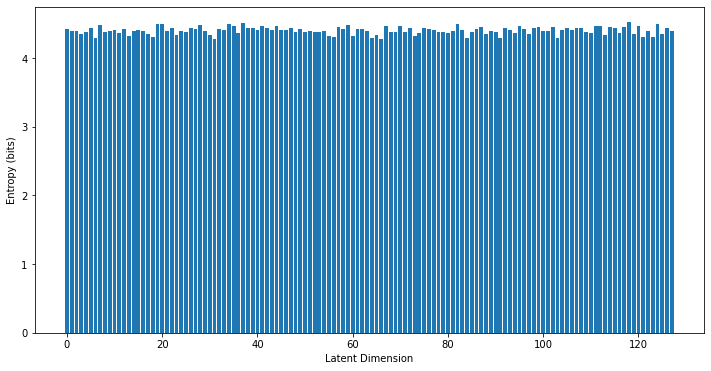

In [25]:
fig = plt.figure(figsize=(12,6))

plt.bar(range(len(vae_entropy_mems)), vae_entropy_mems)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.show()

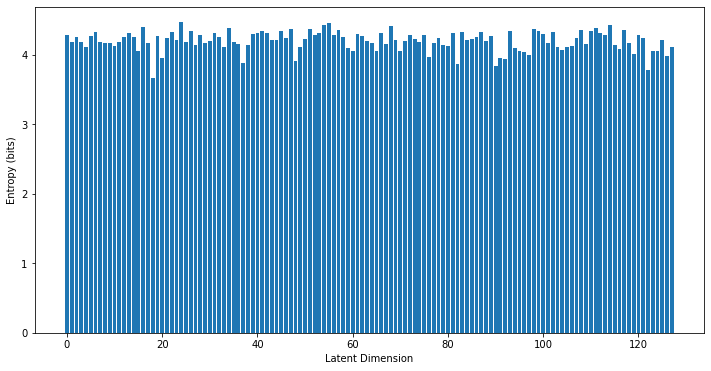

In [26]:
fig = plt.figure(figsize=(12,6))

plt.bar(range(len(vae_entropy_mus)), vae_entropy_mus)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.show()

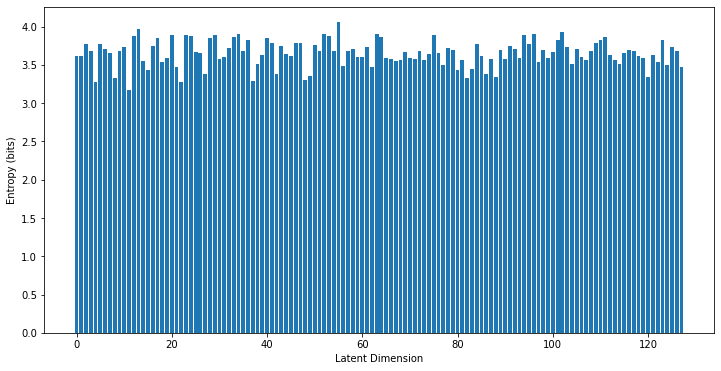

In [27]:
fig = plt.figure(figsize=(12,6))

plt.bar(range(len(vae_entropy_logvars)), vae_entropy_logvars)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.show()

We can see that some dimensions have significantly more information contained across the 25 samples than others and they correspond with the selective memory visualization shown above. We can sum the entropy of all dimensions to find the full model entropy. Again, note that we would need a larger sample size to converge the model entropy.

In [28]:
total_entropy_mems = np.sum(vae_entropy_mems)
print('The model contains {} nats of information'.format(round(total_entropy_mems, 2)))
total_entropy_mus = np.sum(vae_entropy_mus)
print('The model contains {} nats of information'.format(round(total_entropy_mus, 2)))
total_entropy_logvars = np.sum(vae_entropy_logvars)
print('The model contains {} nats of information'.format(round(total_entropy_logvars, 2)))

The model contains 563.24 nats of information
The model contains 537.88 nats of information
The model contains 467.2 nats of information


# Calculating Metrics

There are several metrics we can use to analyze generated samples including %valid, %unique, %novel and cross diversity. You can use the `sample.py` script to generate new molecular structures from a trained model and calculate these metrics on them or calculate them for a different set of saved SMILES strings. %valid and %unique require only the set of generated SMILES which we load a subset of 1000 generated by the `RNNAttn-256` model here.

In [40]:
gen_smiles = pd.read_csv('notebooks//example_data//rnnattn-256_gen.csv').SMILES.to_list()
n_gen_smiles = len(gen_smiles)

valid_smiles = valid(gen_smiles)
n_valid_smiles = len(valid_smiles)
print('{} valid smiles'.format(n_valid_smiles))

NameError: name 'Chem' is not defined

911 of the 1000 generated smiles are valid. This means they are recognizable by RDKit after being sanitized. We can also pass them through an additional set of filters defined by the MOSES framework using the `pass_through_filters` function.

In [17]:
filtered_smiles = pass_through_filters(valid_smiles, '../data')
n_filtered_smiles = len(filtered_smiles)
print('{} filtered smiles'.format(n_filtered_smiles))

887 filtered smiles


887 out of the 911 valid SMILES also pass successfully through the filters meaning these are high quality samples. We can also test for uniqueness. However for the remaining metrics, we need to import our training data as well ***(note - to save calculation time, the full training set is not included in example_data, just a portion of it. These metrics should be validated against the full training set in a real experiment)***

In [18]:
train_smiles = pd.read_csv('example_data/zinc_train_example.txt').smile.to_list()

unique_smiles = unique(filtered_smiles)
novel_smiles = novel(unique_smiles, train_smiles)
n_unique_smiles = len(unique_smiles)
n_novel_smiles = len(novel_smiles)
print('{} unique smiles'.format(n_unique_smiles))
print('{} novel smiles'.format(n_novel_smiles))

887 unique smiles
887 novel smiles


All of our remaining SMILES are both novel (e.g. not present in the training set) and unique (no repeats). To calculate cross diversity we need the fingerprints of each structure which we can calculate with the helper function `fingerprints()`.

In [19]:
gen_fps = fingerprints(novel_smiles)
train_fps = fingerprints(train_smiles)
crossdiv = cross_diversity(gen_fps, train_fps)
crossdiv

0.6274997579455376

The generated samples score a cross diversity of 0.63 out of 1 which indicates they are very unique compared to the training set ***(note - we overestimate this metric in this tutorial due to not using the full training set for this calculation)***